In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# the goal of the notebook - to estimate lipschitz constant

from soul_gan.models.utils import load_gan
from soul_gan.utils.general_utils import DotConfig
from soul_gan.utils.general_utils import ROOT_DIR

import yaml
from pathlib import Path
import numpy as np

import torch
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
import sys
sys.path.append("../thirdparty/studiogan/studiogan")
import studiogan
from soul_gan.models.studiogans import StudioDis, StudioGen

In [4]:
gan_config = yaml.safe_load(Path('../configs/gan_configs/cifar-10-wgan-gp.yml').open('r'))
gan_config = DotConfig(gan_config['gan_config'])

In [5]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

In [6]:
gen, dis = load_gan(gan_config, device, False)

In [19]:
import numpy as np

batch_size = 500
total_n = 1500

grads = np.empty((0, gen.z_dim))
zs = np.empty((0, gen.z_dim))

for _ in range(0, total_n, batch_size):
    z = gen.prior.sample((batch_size,))
    z.requires_grad_(True)
    dgz = dis(gen(z)).squeeze()
    print(gen.prior.log_prob(z).shape, dgz.shape)
    energy = gen.prior.log_prob(z) + dgz
    #energy = dgz
    grad = torch.autograd.grad(energy.sum(), z)[0]
    grads = np.concatenate([grads, grad.detach().cpu().numpy()], 0)
    zs = np.concatenate([zs, z.detach().cpu().numpy()], 0)
      
f_diffs = np.linalg.norm(grads[:, None, :] - grads[None, :, :], axis=-1)
z_diffs = np.linalg.norm(zs[:, None, :] - zs[None, :, :], axis=-1)
l_est = f_diffs / (z_diffs + np.eye(zs.shape[0]))
#l_est = l_est.max()

torch.Size([500]) torch.Size([500])
torch.Size([500]) torch.Size([500])
torch.Size([500]) torch.Size([500])


In [14]:
torch.autograd.grad(gen.prior.log_prob(z).sum(), z)[0]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

/home/lagutin/anaconda3/envs/soul2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

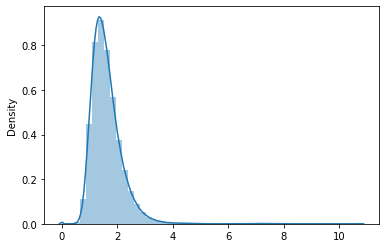

In [20]:
import seaborn as sns

sns.distplot(l_est.tolist())

In [20]:
l_est

0.0

In [8]:
def estimate_lipschitz_const(gen, dis, n_steps, batch_size):
    lipschitz_const_est = 0
    for step_id in range(n_steps):
        z = gen.prior.sample((batch_size,)).requires_grad_(True)
        x_fake = gen(z)
        dis_fake = dis(x_fake)
        energy = gen.prior.log_prob(z) + dis_fake
        grad = torch.autograd.grad(energy.sum(), z)[0]
        grad_norm = torch.norm(grad, dim=1).mean()
        lipschitz_const_est += grad_norm.item() / n_steps
    
    return lipschitz_const_est

In [10]:
lipschitz_const_est = estimate_lipschitz_const(gen, dis, 10, 100)

In [11]:
1./ lipschitz_const_est


0.023126984155831466